In [17]:
# cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

In [18]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [19]:
### Set file names
runningLocation = 'local'
if  runningLocation== 'local':
    hisOSSEFilePath='../data/raw/newRepeat/'
    hisTruthFilePath='../data/raw/truth/final/'
    # modTruthFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/obs_truth_output_noRepeat/' # output mod files from truth run. 
    obsFinalFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/' #the 'final' obs files: Verification obs, + NLmodel values from modTruth.
    modOSSEFilePath='../data/raw/newRepeat/'
    # hisPertFilePath='../data/raw/perturbed/'
elif runningLocation == 'gdata':
    hisOSSEFilePath='/g/data/fu5/eac/OSSEs/OSSE_ssh_only/output/'
    hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings
    obsFinalFilePath='/g/data/fu5/deg581/obs/SSH_SST/final/'
    modOSSEFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
    hisPertFilePath='/g/data/fu5/deg581/EAC_2yr_perturbedRun_final/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='eac_obs_'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

### Load functions

In [20]:
### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

# Check obs files with repeated values wit new merge method

In [21]:
timeRange = [8001, 8021]

## 
datelist = np.array(range(timeRange[0],timeRange[1],4))

loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/eac_obs_8001.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/eac_obs_8005.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/eac_obs_8009.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/eac_obs_8013.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/eac_obs_8017.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/eac_obs_8001.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/eac_obs_8005.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/eac_obs_8009.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_identicalTracks/eac_obs_8013.nc
loading  /Users/dav

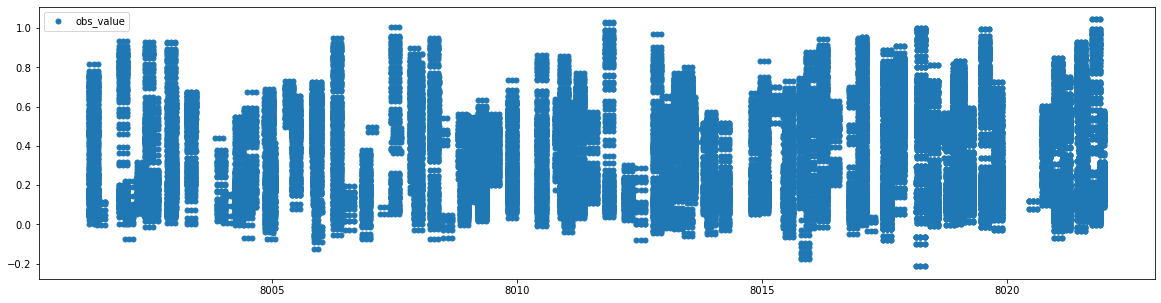

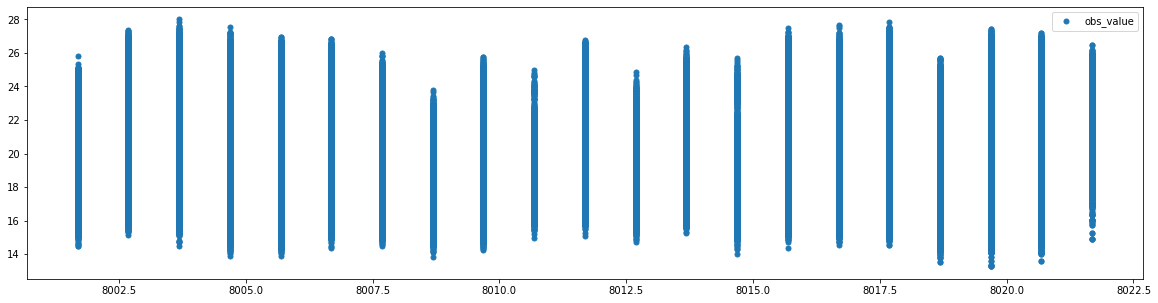

In [22]:
pRange=(405)

fig = plt.figure(figsize=(20,5))
ax = plt.axes()

for dates in datelist:

    filenameObs=obsFinalFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()

pRange=(340)

#%matplotlib qt 
fig = plt.figure(figsize=(20,5))
ax = plt.axes()

for dates in datelist:

    filenameObs=obsFinalFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
plt.show()

    # pRange=(340)
    # v=mod.NLmodel_final.where(obs.obs_provenance==pRange)
    # vi=mod.NLmodel_initial.where(obs.obs_provenance==pRange)
    # vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    # lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    # la=obs.obs_lat.where(obs.obs_provenance==pRange)
    # t=obs.obs_time.where(obs.obs_provenance==pRange)
    # fig = plt.figure(figsize=(10,5))
    # ax = plt.axes()
    # ax.plot(t, v, marker='.', markersize=1, lineStyle='None',label='NLmodel_final',zorder=10)
    # ax.plot(t, vi, marker='.', markersize=5, lineStyle='None',label='NLmodel_initial',zorder=5)
    # ax.plot(t, vobs, marker='.', markersize=10, lineStyle='None',label='obs_value',zorder=1)
    # ax.legend()
    # print(v.mean())

# Now plot results

In [23]:
timeRange = [8005, 8025]
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

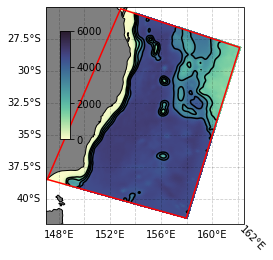

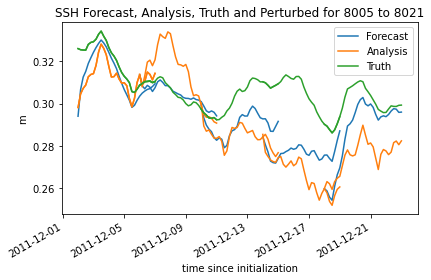

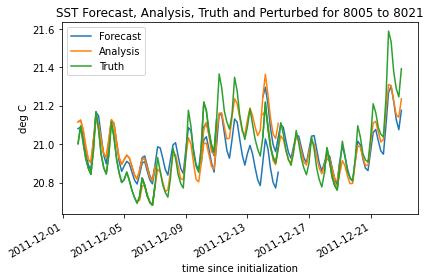

In [24]:
### Now same but for 'upstream' area

etaRangeMetric = [0, 315] #[115, 200]
xiRangeMetric = [0, 270] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =hisPertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

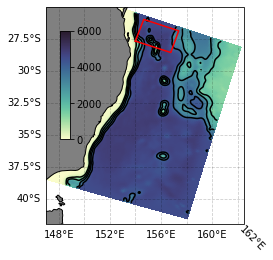

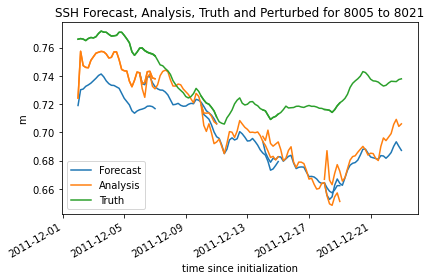

In [25]:
etaRangeMetric = [270, 310] #[115, 200]
xiRangeMetric = [75, 175] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =hisPertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()
#plt.xlim(['2012-01-15','2012-02-15'])

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

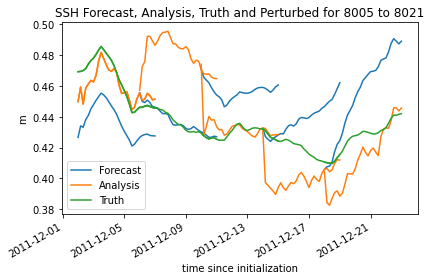

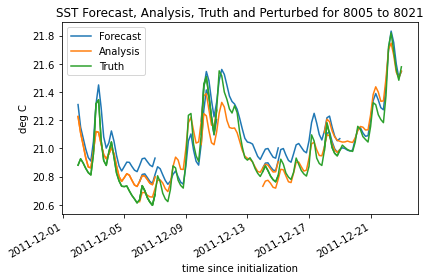

In [26]:
etaRangeMetric = [70, 185] #[115, 200]
xiRangeMetric = [105, 185] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =hisPertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()
#plt.xlim(['2012-01-15','2012-02-15'])

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

In [27]:
### Open truth file
OverlappedTruthFiles = 'yes'
if OverlappedTruthFiles == 'yes':
    truth = loadOverlappedNetcdf(hisTruthFilePath,prefixTruth,filestring='080[0-4]*.nc',overlapDays=7)
elif OverlappedTruthFiles == 'no':
    import glob
    chunks = {'ocean_time':1}

    filelist = glob.glob(hisTruthFilePath+prefixTruth+'0800*.nc')
    #datelist = np.array(range(timeRange[0],timeRange[1],4))

    for files in filelist: 
        print(files)
        # filelist.append(files)
    truth = xr.open_mfdataset(filelist,chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right') 
    # truth = dropDuplicateTimes(truth)

loaded from ../data/raw/truth/final/outer_his_08001.nc to ../data/raw/truth/final/outer_his_08049.nc


In [28]:

# pert = loadOverlappedNetcdf(hisPertFilePath,prefixPert,filestring='080[0-2]*.nc',overlapDays=7)

In [29]:
osseAna = loadOSSE(hisOSSEFilePath,prefixAnalysis,filestring='08*.nc',overlapDays=7)
osseFore = loadOSSE(hisOSSEFilePath,prefixForecast,filestring='08*.nc',overlapDays=7)


loaded from ../data/raw/newRepeat/roms_fwd_outer1_08005.nc to ../data/raw/newRepeat/roms_fwd_outer1_08017.nc
loaded from ../data/raw/newRepeat/roms_fwd_outer0_08005.nc to ../data/raw/newRepeat/roms_fwd_outer0_08017.nc


In [74]:
#xiRangeMetric = [85, 150] # upstream
#etaRangeMetric = [115, 200] #upstream
etaRangeMetric = [0, 315] # whole domain
xiRangeMetric = [0, 270] # whole domain

err,ssh_rmse_Ana_Truth = calc_rmseSpatial(osseAna.zeta,truth.zeta,etaRangeMetric,xiRangeMetric)
err,ssh_rmse_Fore_Truth = calc_rmseSpatial(osseFore.zeta,truth.zeta,etaRangeMetric,xiRangeMetric)
err,ssh_rmse_Ana_Fore = calc_rmseSpatial(osseAna.zeta,osseFore.zeta,etaRangeMetric,xiRangeMetric)
# err,ssh_rmse_Pert_Truth = calc_rmseSpatial(pert.zeta,truth.zeta,etaRangeMetric,xiRangeMetric)

names = ('ssh_rmse_Fore_Truth','ssh_rmse_Ana_Truth','ssh_rmse_Ana_Fore')
xlabels = ('m','m','m','m')
rmse_metrics = xr.Dataset()

for name in names:
    rmse_metrics[name] = eval(name)

/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarni

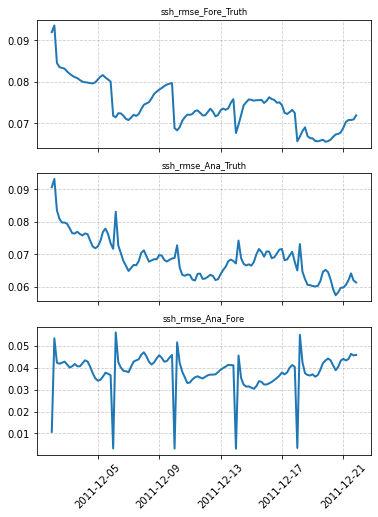

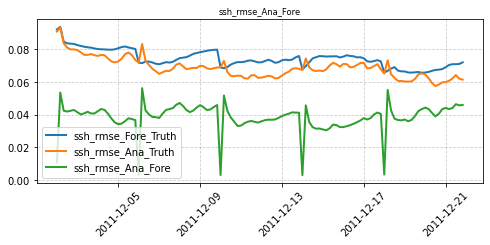

In [100]:


plt_params = {'linewidth':2}


fig, axes = plt.subplots(3, figsize=(6, 8), sharex=True)
for ax, run in zip(axes, names):
    simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics[run],ax=ax, plt_kwargs=plt_params)
    ax.set_title(run, fontsize='small',loc='center')
    ax.tick_params('x',labelrotation=45)



fig, ax = plt.subplots(1, figsize=(8,3), sharex=True)
for run in names:
    plt_params['label'] = run
    simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics[run],ax=ax, plt_kwargs=plt_params)
ax.set_title(run, fontsize='small',loc='center')
ax.legend()
ax.tick_params('x',labelrotation=45)

In [95]:
sshForecast.ocean_time.values

array(['2011-12-02T00:00:00.000000000', '2011-12-02T04:00:00.000000000',
       '2011-12-02T08:00:00.000000000', '2011-12-02T12:00:00.000000000',
       '2011-12-02T16:00:00.000000000', '2011-12-02T20:00:00.000000000',
       '2011-12-03T00:00:00.000000000', '2011-12-03T04:00:00.000000000',
       '2011-12-03T08:00:00.000000000', '2011-12-03T12:00:00.000000000',
       '2011-12-03T16:00:00.000000000', '2011-12-03T20:00:00.000000000',
       '2011-12-04T00:00:00.000000000', '2011-12-04T04:00:00.000000000',
       '2011-12-04T08:00:00.000000000', '2011-12-04T12:00:00.000000000',
       '2011-12-04T16:00:00.000000000', '2011-12-04T20:00:00.000000000',
       '2011-12-05T00:00:00.000000000', '2011-12-05T04:00:00.000000000',
       '2011-12-05T08:00:00.000000000', '2011-12-05T12:00:00.000000000',
       '2011-12-05T16:00:00.000000000', '2011-12-05T20:00:00.000000000',
       '2011-12-06T00:00:00.000000000', '2011-12-06T04:00:00.000000000',
       '2011-12-06T08:00:00.000000000', '2011-12-06

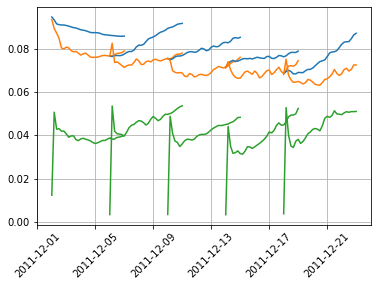

In [101]:

datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

fig, ax = plt.subplots(1)

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    Ana_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshTruth)**2,axis=2),axis=1))
    Fore_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast-sshTruth)**2,axis=2),axis=1))
    Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    time = sshForecast.ocean_time.values

    ax.plot(time, Fore_Truth, color="C0",label='Forecast')
    ax.plot(time, Ana_Truth, color="C1",label='Analysis')
    ax.plot(time, Ana_Fore, color="C2",label='Truth')
    
ax.grid()
ax.tick_params('x',labelrotation=45)


<ipython-input-35-ef826c6ab0eb>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5), subplot_kw={'projection': ccrs.PlateCarree()})


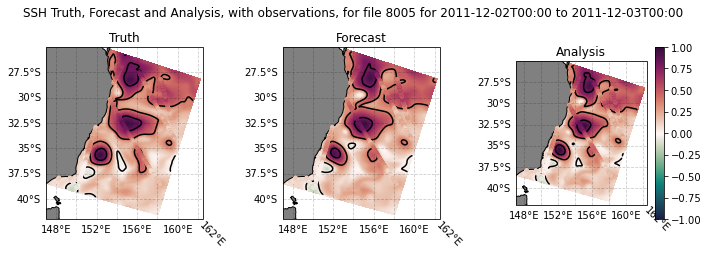

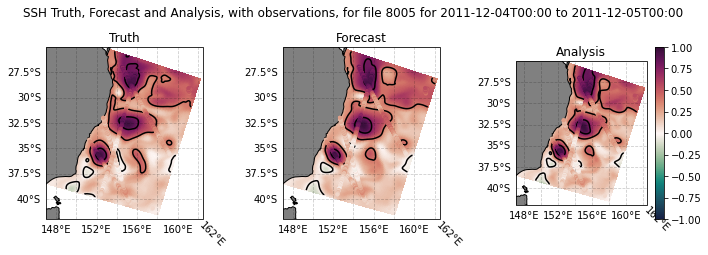

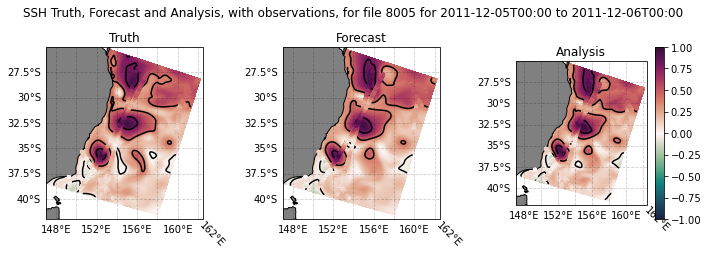

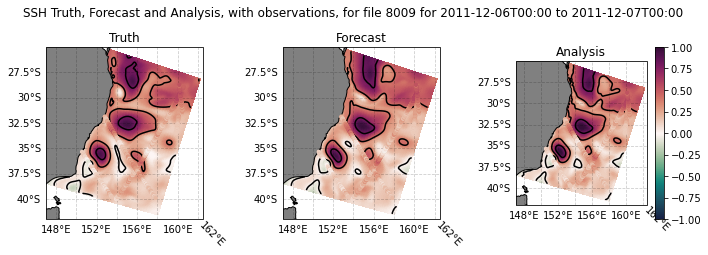

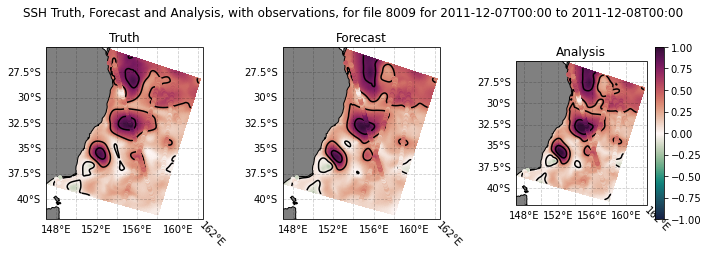

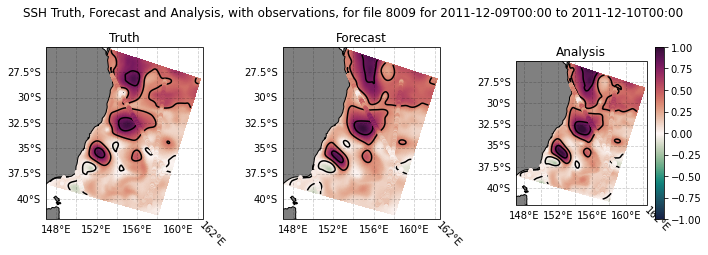

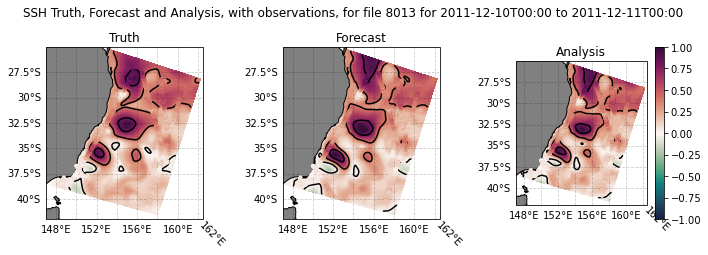

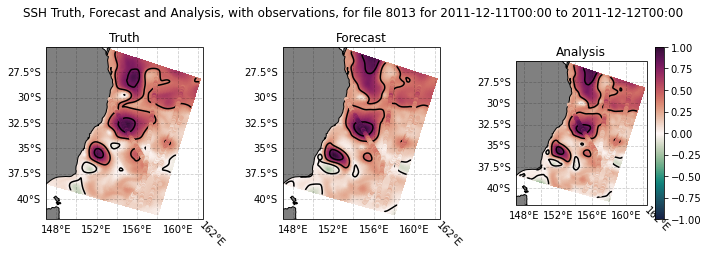

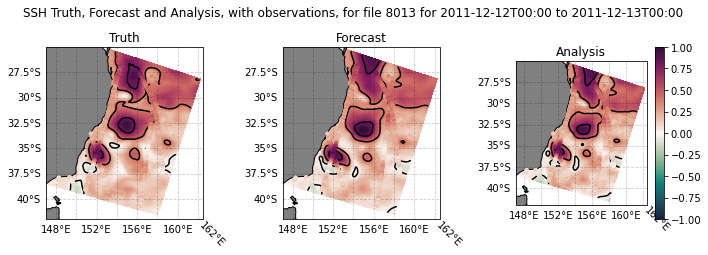

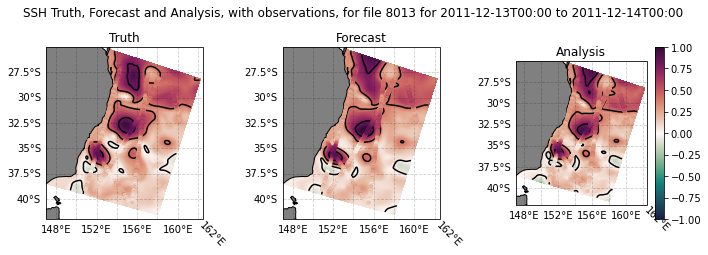

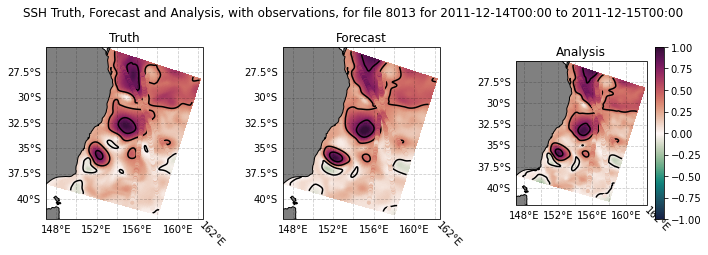

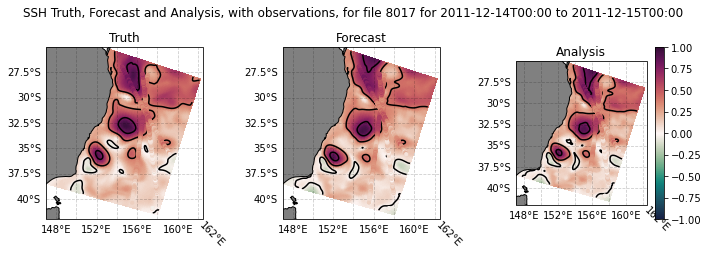

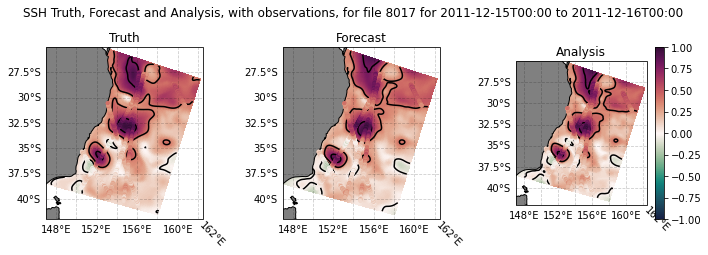

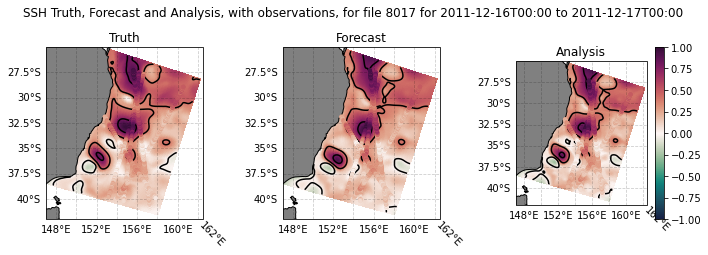

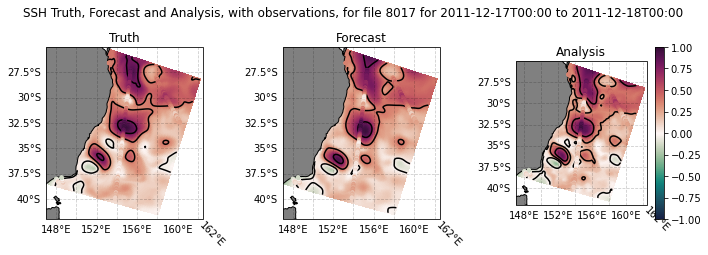

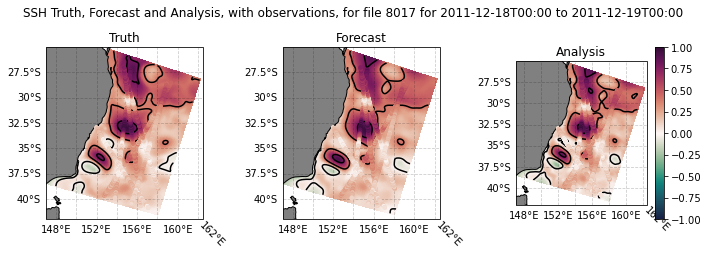

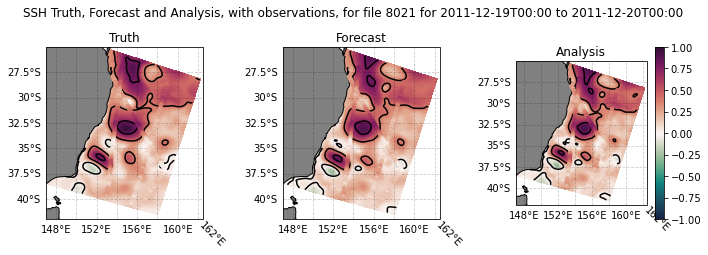

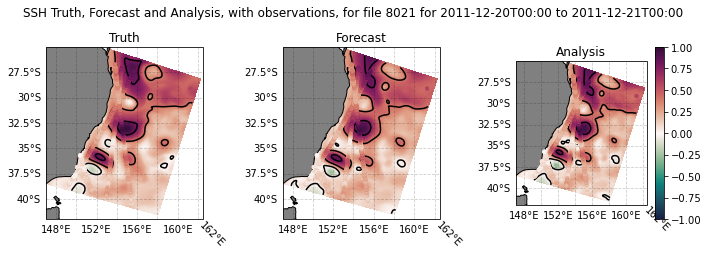

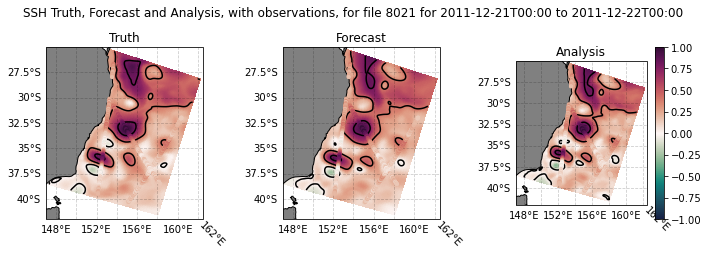

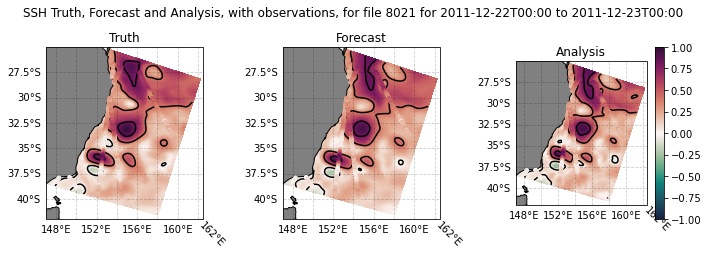

In [35]:
timeRange = [8005, 8025]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5), subplot_kw={'projection': ccrs.PlateCarree()})

        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([-1,1])
        sc.set_clim([-1,1])
        ax.set_title('Truth')

        toPlotData = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[1]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([-1,1])
        sc.set_clim([-1,1])
        ax.set_title('Forecast')


        toPlotData = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[2]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([-1,1])
        sc.set_clim([-1,1])
        ax.set_title('Analysis')


        plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Truth, Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')
        plt.tight_layout()
        figName = outFigurePath+'SSHdiff_'+str(dates)+'_day'+str(int(tChunk/timeOutputs+1))+'.png'
        # plt.savefig(figName,format='png',bbox_inches='tight')






In [54]:
timePeriod = 4  #days
timeOutputs = 3 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

timeRange = [8005, 8025]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)

        Xvals=mod.obs_Xgrid.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True).values.round() #xi
        Yvals=mod.obs_Ygrid.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True).values.round() #eta

        # for ii in range(len(Xvals)):
        #     # nothing


        
        toPlotData = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
 
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
    
        toPlotData = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)


        toPlotData = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
   
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
    






In [200]:
timePeriod = 4  #days
timeOutputs = 1 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

timeRange = [8005, 8025]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

rr=0
timeVec = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHobs = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_fore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_anal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHtruth = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()
    
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
    obs=xr.open_dataset(filenameObs).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)
        # print(tChunk,time1,time2,time1sd,time2sd)
        timeVec[rr]=np.nanmean([time1sd,time2sd])

        modVal = mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modAnal = mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modFore = mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        meanSSHobs[rr] = np.nanmean(modVal)
        meanSSHanal_obsspace[rr] = np.nanmean(modAnal)
        meanSSHfore_obsspace[rr] = np.nanmean(modFore)
        rmsSSHerror_fore_obsspace[rr] = np.sqrt(((modFore - modVal)**2).mean(dim='datum',skipna=True))
        rmsSSHerror_anal_obsspace[rr] = np.sqrt(((modAnal - modVal)**2).mean(dim='datum',skipna=True))

        meanSSHtruth[rr] = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHfore[rr]  = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHanal[rr]  = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)

        rr=rr+1




<ipython-input-200-b3177ba0f775>:47: RuntimeWarning: Mean of empty slice
  meanSSHobs[rr] = np.nanmean(modVal)
<ipython-input-200-b3177ba0f775>:48: RuntimeWarning: Mean of empty slice
  meanSSHanal_obsspace[rr] = np.nanmean(modAnal)
<ipython-input-200-b3177ba0f775>:49: RuntimeWarning: Mean of empty slice
  meanSSHfore_obsspace[rr] = np.nanmean(modFore)
<ipython-input-200-b3177ba0f775>:47: RuntimeWarning: Mean of empty slice
  meanSSHobs[rr] = np.nanmean(modVal)
<ipython-input-200-b3177ba0f775>:48: RuntimeWarning: Mean of empty slice
  meanSSHanal_obsspace[rr] = np.nanmean(modAnal)
<ipython-input-200-b3177ba0f775>:49: RuntimeWarning: Mean of empty slice
  meanSSHfore_obsspace[rr] = np.nanmean(modFore)
<ipython-input-200-b3177ba0f775>:47: RuntimeWarning: Mean of empty slice
  meanSSHobs[rr] = np.nanmean(modVal)
<ipython-input-200-b3177ba0f775>:48: RuntimeWarning: Mean of empty slice
  meanSSHanal_obsspace[rr] = np.nanmean(modAnal)
<ipython-input-200-b3177ba0f775>:49: RuntimeWarning: Mean

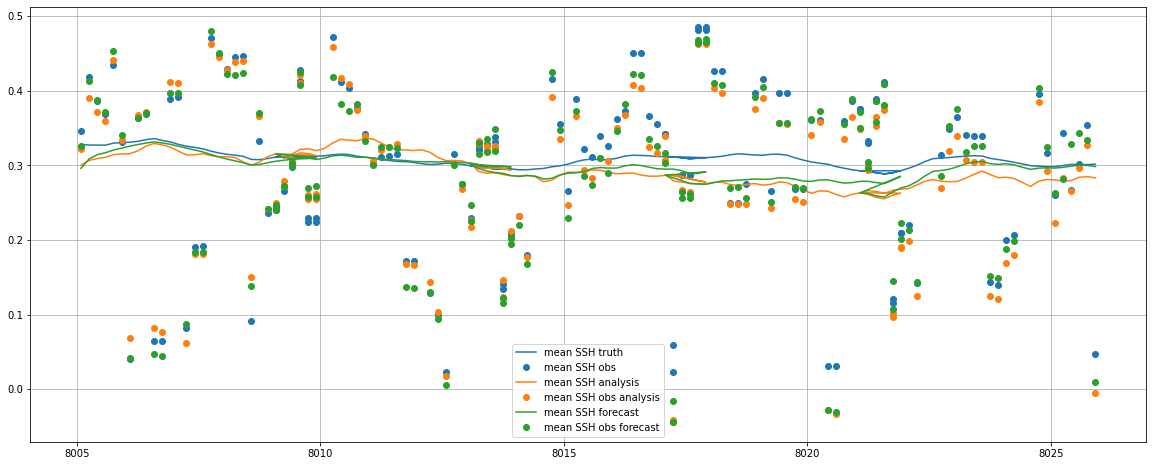

In [203]:

fig,ax = plt.subplots(1,figsize=(20,8))
ax.plot(timeVec,meanSSHtruth,linestyle='-',color="C0",label='mean SSH truth')
ax.plot(timeVec,meanSSHobs,linestyle='none',marker='o',color="C0",label='mean SSH obs')
ax.plot(timeVec,meanSSHanal,linestyle='-',color="C1",label='mean SSH analysis')
ax.plot(timeVec,meanSSHanal_obsspace,linestyle='none',marker='o',color="C1",label='mean SSH obs analysis')
ax.plot(timeVec,meanSSHfore,linestyle='-',color="C2",label='mean SSH forecast')
ax.plot(timeVec,meanSSHfore_obsspace,linestyle='none',marker='o',color="C2",label='mean SSH obs forecast')
ax.grid()
ax.legend()

In [34]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

timeRange = [8005, 8013]
datelist = np.array(range(timeRange[0],timeRange[1],4))

filenameBRAN='/g/data/fu5/eac/20year_run_Junde/bluelink_to_roms/data/out/BRAN2020_ssh.nc'
bran=xr.open_dataset(filenameBRAN)
bran = bran.set_coords(['lon_rho','lat_rho'])

provValue=405

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
#     mod=xr.open_dataset(filenameMod).load()
    obs=xr.open_dataset(filenameObs).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(1,5, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = bran.ssh.sel(ocean_time=slice(time1-np.timedelta64(1,'s'),time2-np.timedelta64(1,'s'))).mean(dim='ocean_time',skipna=True)
        ax=axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([-1,1])
        ax.set_title('BRAN')      
        
        toPlotData = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[1]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.left_labels = False
        gl.top_labels = False     
        im.set_clim([-1,1])
        ax.set_title('Truth')
        
        ax = axes[2]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>=time1sd) & (obs.obs_time<time2sd), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>=time1sd) & (obs.obs_time<time2sd), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>=time1sd) & (obs.obs_time<time2sd), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>=time1sd) & (obs.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        ax.set_title('Obs')
        
        toPlotData = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[3]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Forecast')


        toPlotData = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[4]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False  
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        fig.colorbar(im, ax=axes.ravel().tolist())
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Truth, Obs Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')
#         plt.tight_layout()
        figName = outFigurePath+'SSHdiff_'+str(dates)+'_day'+str(int(tChunk/timeOutputs+1))+'.png'
        # plt.savefig(figName,format='png',bbox_inches='tight')






FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/fu5/eac/20year_run_Junde/bluelink_to_roms/data/out/BRAN2020_ssh.nc'

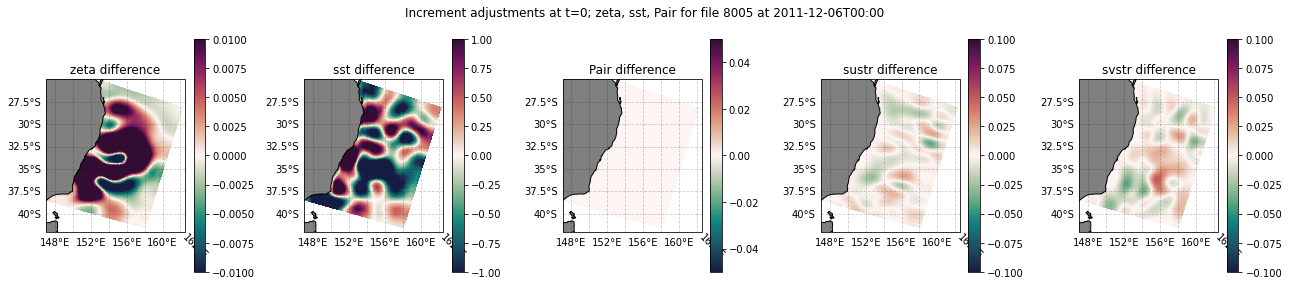

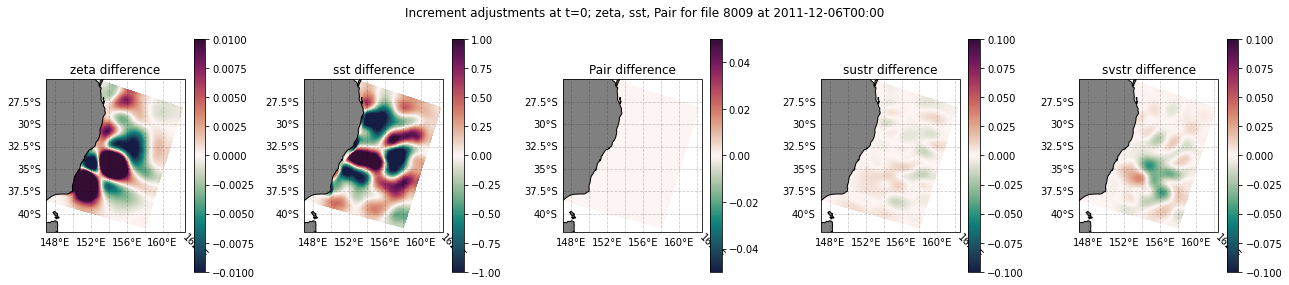

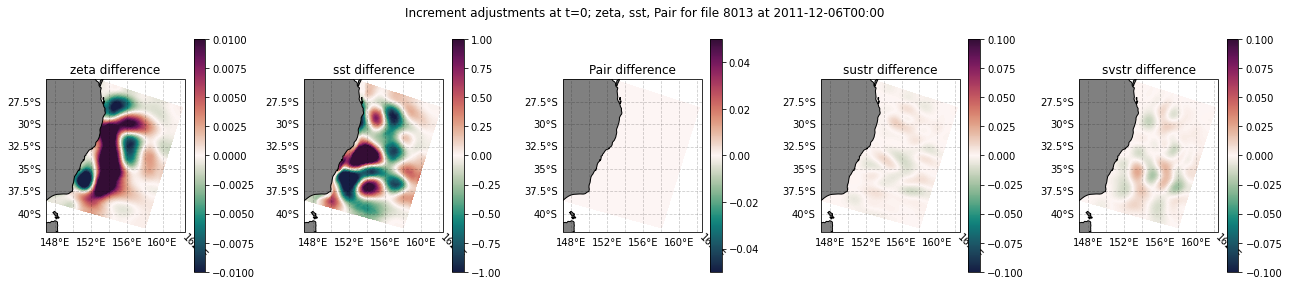

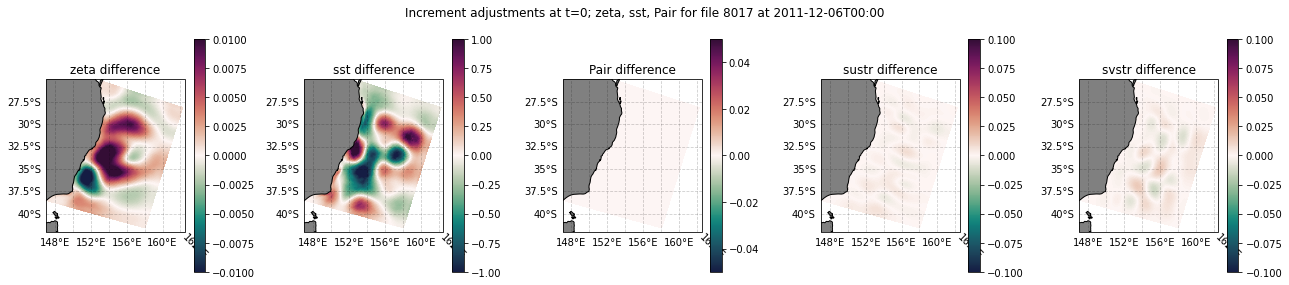

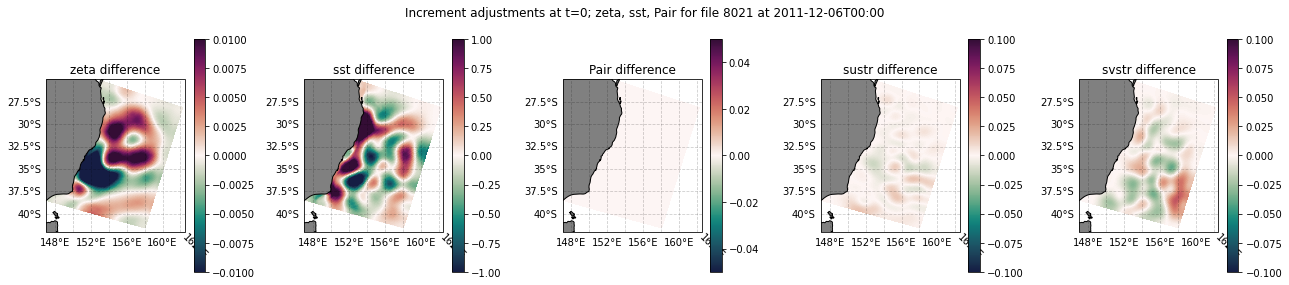

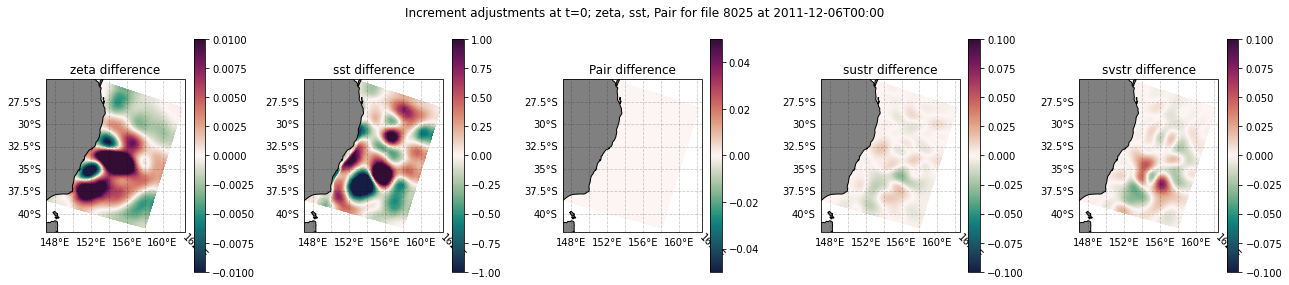

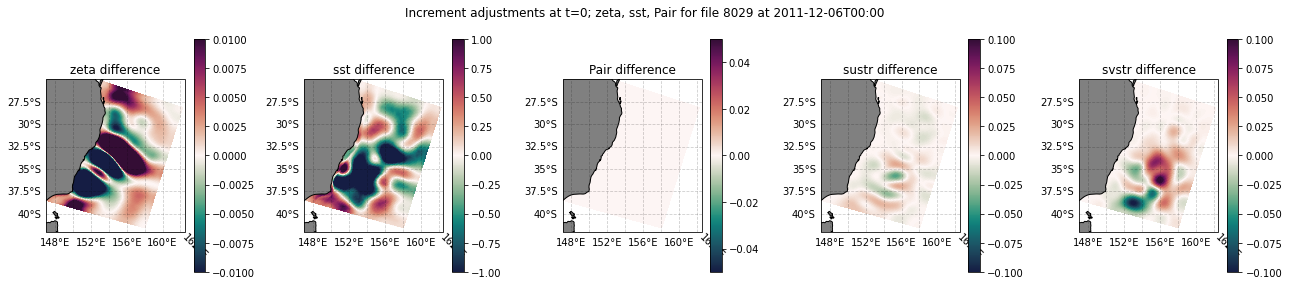

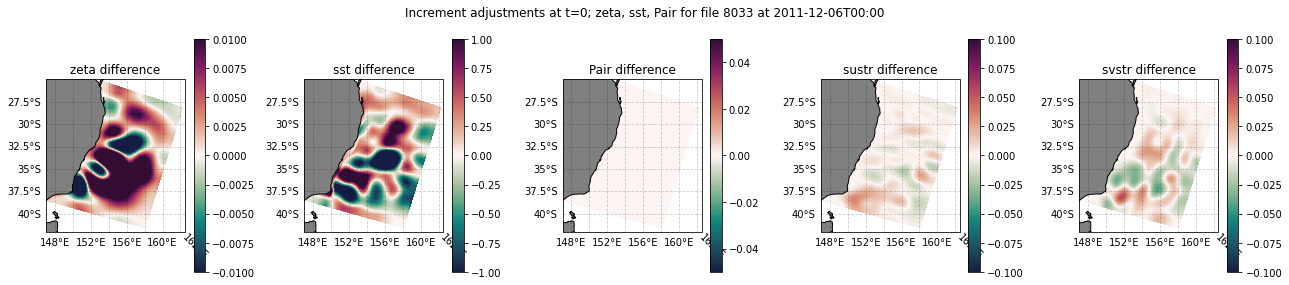

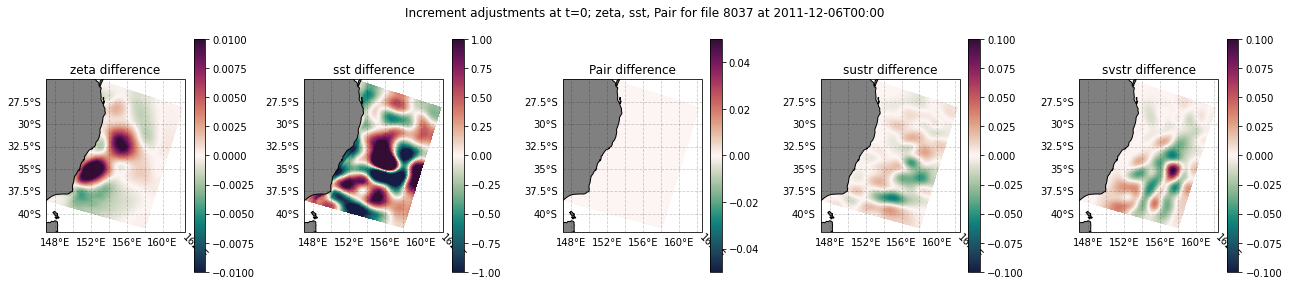

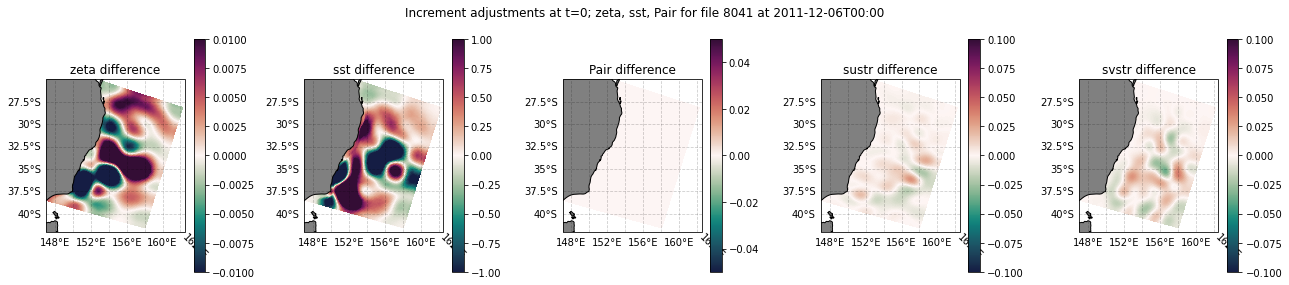

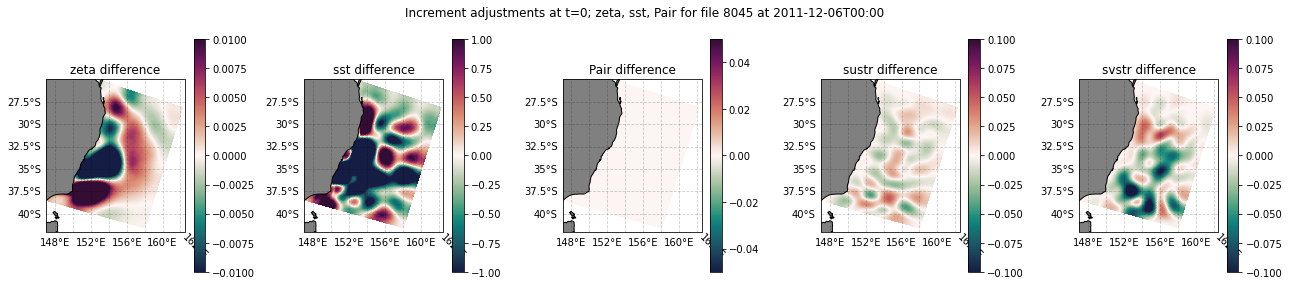

In [ ]:
# Plot the increment adjustments
timeRange = [8005, 8049]

datelist = np.array(range(timeRange[0],timeRange[1],4))
# datelist = np.array([8009])
provValue=405
timeOutputs=1

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    Forecast=xr.open_dataset(filenameForecast)
    Analysis=xr.open_dataset(filenameAnalysis)
    # sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    # filenameObs=obsFilePath+prefixObs+''+str(dates)+'.nc'
    # obs=xr.open_dataset(filenameObs).load()

    tChunk=0

    fig, axes = plt.subplots(ncols=5, figsize=(18, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    time1=sshTruth.coords['ocean_time'].values[tChunk]
    time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
    time1sd=datestring_to_serial_day(time1) 
    time2sd=datestring_to_serial_day(time2) 
    
    Fore_time0 = Forecast.isel(ocean_time=tChunk).squeeze()
    Ana_time0 = Analysis.isel(ocean_time=tChunk).squeeze()

    sshDiff = Fore_time0.zeta - Ana_time0.zeta
    sstDiff = Fore_time0.temp.isel(s_rho=-1) - Ana_time0.temp.isel(s_rho=-1)
    pAirDiff = Fore_time0.Pair - Ana_time0.Pair
    sustrDiff = Fore_time0.sustr - Ana_time0.sustr
    svstrDiff = Fore_time0.svstr - Ana_time0.svstr


 
    ax = axes[0]
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=sshDiff.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
    # v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
    gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False     
    im.set_clim([-.01,.01])
    plt.colorbar(im, ax=ax)
    ax.set_title('zeta difference')

    ax = axes[1]
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=sstDiff.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
    # v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
    gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False     
    im.set_clim([-1,1])
    plt.colorbar(im, ax=ax)
    ax.set_title('sst difference')


    ax = axes[2]
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=pAirDiff.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
    # v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
    gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False     
    # im.set_clim([-.0001,.0001])
    plt.colorbar(im, ax=ax)
    ax.set_title('Pair difference')

    ax = axes[3]
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=sustrDiff.plot.pcolormesh('lon_u','lat_u',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
    # v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
    gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False     
    im.set_clim([-.1,.1])
    plt.colorbar(im, ax=ax)
    ax.set_title('sustr difference')

    ax = axes[4]
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=svstrDiff.plot.pcolormesh('lon_v','lat_v',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
    # v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
    # sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
    gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False     
    im.set_clim([-.1,.1])
    plt.colorbar(im, ax=ax)
    ax.set_title('svstr difference')
    
    date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
    fig.suptitle('Increment adjustments at t=0; zeta, sst, Pair for file '+str(dates)+' at '+date1[:-13])
    plt.ylabel('m')
    plt.tight_layout()
    # figName = outFigurePath+'img_'+str(tChunk)+'.png'
        # plt.savefig(figName,format='png',bbox_inches='tight',dpi=120)


In [ ]:
# Plot the MEAN increment adjustment

datelist = np.array(range(timeRange[0],timeRange[1],4))
# datelist = np.array([8009])
provValue=405
timeOutputs=1

sshDiff = np.zeros([len(datelist),grid.lon_rho.shape[0],grid.lon_rho.shape[1]])
sstDiff = np.zeros([len(datelist),grid.lon_rho.shape[0],grid.lon_rho.shape[1]])
pAirDiff = np.zeros([len(datelist),grid.lon_rho.shape[0],grid.lon_rho.shape[1]])
sustrDiff = np.zeros([len(datelist),grid.lon_u.shape[0],grid.lon_u.shape[1]])
svstrDiff = np.zeros([len(datelist),grid.lon_v.shape[0],grid.lon_v.shape[1]])

for dates,rr in zip(datelist,range(len(datelist))):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    Forecast=xr.open_dataset(filenameForecast)
    Analysis=xr.open_dataset(filenameAnalysis)
    # sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    # filenameObs=obsFilePath+prefixObs+''+str(dates)+'.nc'
    # obs=xr.open_dataset(filenameObs).load()

    tChunk=0

    time1=sshTruth.coords['ocean_time'].values[tChunk]
    time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
    time1sd=datestring_to_serial_day(time1) 
    time2sd=datestring_to_serial_day(time2) 
    
    Fore_time0 = Forecast.isel(ocean_time=tChunk).squeeze()
    Ana_time0 = Analysis.isel(ocean_time=tChunk).squeeze()

    sshDiff_temp = Fore_time0.zeta - Ana_time0.zeta
    sstDiff_temp = Fore_time0.temp.isel(s_rho=-1) - Ana_time0.temp.isel(s_rho=-1)
    pAirDiff_temp = Fore_time0.Pair - Ana_time0.Pair
    sustrDiff_temp = Fore_time0.sustr - Ana_time0.sustr
    svstrDiff_temp = Fore_time0.svstr - Ana_time0.svstr

    sshDiff[rr] = sshDiff_temp.values
    sstDiff[rr] = sstDiff_temp.values
    pAirDiff[rr] = pAirDiff_temp.values
    sustrDiff[rr] = sustrDiff_temp.values
    svstrDiff[rr] = svstrDiff_temp.values



sshDiffMean = np.nanmean(sshDiff,axis=0)
sstDiffMean = np.nanmean(sstDiff,axis=0)
pAirDiffMean = np.nanmean(pAirDiff,axis=0)
sustrDiffMean = np.nanmean(sustrDiff,axis=0)
svstrDiffMean = np.nanmean(svstrDiff,axis=0)

/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


In [ ]:
print(np.nanmean(np.nanmean(sshDiffMean,axis=0),axis=0))
print(np.nanmean(np.nanmean(sstDiffMean,axis=0),axis=0))
print(np.nanmean(np.nanmean(pAirDiffMean,axis=0),axis=0))
print(np.nanmean(np.nanmean(sustrDiffMean,axis=0),axis=0))
print(np.nanmean(np.nanmean(svstrDiffMean,axis=0),axis=0))


0.001526677740009216
-0.06093099982314679
0.0
-0.0002241481430452417
-0.0008862910746748288


/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


Text(0.5, 1.0, 'svstr increment difference')

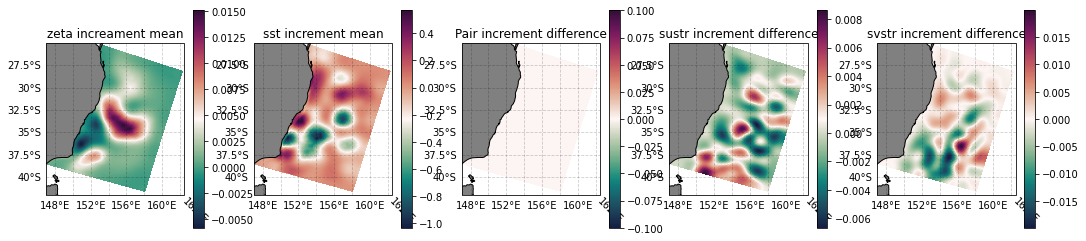

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(18, 4), subplot_kw={'projection': ccrs.PlateCarree()})


ax = axes[0]
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
toPlotData = sshDiffMean
im = ax.pcolormesh(grid.lon_rho,grid.lat_rho,toPlotData,cmap=cmocean.cm.curl)
gl = ax.gridlines(draw_labels=True,
                color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False     
# im.set_clim([-.01,.01])
plt.colorbar(im, ax=ax)
ax.set_title('zeta increament mean')

ax = axes[1]
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
toPlotData = sstDiffMean
im = ax.pcolormesh(grid.lon_rho,grid.lat_rho,toPlotData,cmap=cmocean.cm.curl)
gl = ax.gridlines(draw_labels=True,
                color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False     
# im.set_clim([-1,1])
plt.colorbar(im, ax=ax)
ax.set_title('sst increment mean')


ax = axes[2]
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
toPlotData = pAirDiffMean
im = ax.pcolormesh(grid.lon_rho,grid.lat_rho,toPlotData,cmap=cmocean.cm.curl)
gl = ax.gridlines(draw_labels=True,
                color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False     
# im.set_clim([-.0001,.0001])
plt.colorbar(im, ax=ax)
ax.set_title('Pair increment difference')

ax = axes[3]
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
toPlotData = sustrDiffMean
im = ax.pcolormesh(grid.lon_u,grid.lat_u,toPlotData,cmap=cmocean.cm.curl)
gl = ax.gridlines(draw_labels=True,
                color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False     
# im.set_clim([-.1,.1])
plt.colorbar(im, ax=ax)
ax.set_title('sustr increment difference')

ax = axes[4]
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
toPlotData = svstrDiffMean
im = ax.pcolormesh(grid.lon_v,grid.lat_v,toPlotData,cmap=cmocean.cm.curl)
gl = ax.gridlines(draw_labels=True,
                color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False     
# im.set_clim([-.1,.1])
plt.colorbar(im, ax=ax)
ax.set_title('svstr increment difference')